# Tutorial 6: Transformers y BERT.

### Cuerpo Docente

- Profesores: [Andrés Abeliuk](https://aabeliuk.github.io/), [Fabián Villena](https://villena.cl/).
- Profesor Auxiliar: Martín Paredes


### Objetivos del Tutorial

- Introducir la arquitectura de Transformers.
- Hablar de BERT un modelo lenguaje, que revolucionó el NLP.
- Revisar como extraer características de BERT, para resolver una tarea especifica.


> ### Tutorial basado en [El <i>2do Workshop Argentino de NLP - Córdoba 2023</i>](https://github.com/nanom/llm_adaptation_2nlp_workshop/tree/main).

# **IMPORTANTE**

* Todas las celdas indicadas con el símbolo ( ❗ ) son obligatorias y necesarias para el correcto funcionamiento de este taller.

* Aquellas señaladas con ( 🔎 ) son de profundización de contenido, optativas de leer y computar.

* Si una celda contiene el símbolo ( ⏳ ), significa que tomará más tiempo en computarse que el promedio. Tener en cuenta para aprovechar al máximo el tiempo disponible del taller.

# 0 - Inicialización de la notebook

In [1]:
# @markdown ❗
# Instalación de librerías
!pip install -U transformers[torch] --quiet
!pip install -U tabulate --quiet
!pip install -U datasets --quiet
!pip install -U evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 18.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00


In [ ]:
# @markdown ❗
# Descarga de datasets
import os

ROOT_PATH = "llm_adaptation_2nlp_workshop"
DATASETS_PATH = os.path.join(ROOT_PATH, "datasets")

%rm -r "$ROOT_PATH"
!git clone https://github.com/nanom/llm_adaptation_2nlp_workshop.git "$ROOT_PATH"

Cloning into 'llm_adaptation_2nlp_workshop'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 94 (delta 42), reused 86 (delta 38), pack-reused 0 (from 0)
Receiving objects: 100% (94/94), 23.38 MiB | 20.91 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [ ]:
# @markdown ❗
# Comprobación de recursos (GPUs)
!nvidia-smi

Tue Aug 26 02:34:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 1 - Modelos de lenguaje

## ¿Qué son los "modelos de lenguaje"?

- Son modelos estadísticos predictivos, basados en aprendizaje automático sobre textos.
- Su función principal es **analizar** y/o **generar** texto de manera automática.
- Se entrenan encontrando patrones en grandes cantidades de texto libre.
- Dado un contexto (e.g. una secuencia de palabras), aplican los patrones inferidos para predecir la palabra siguiente, generando texto plausible y coherente.
- Si bien los modelos de lenguaje existen desde hace varias décadas en diferentes formas (modelos markovianos, conditional random fields, redes neuronales recurrentes), actualmente cuando alguien habla de un "Modelo de Lenguaje", usualmente se refiere a un modelo neuronal de tipo **Transformer**.

### ¿Qué es un **Transformer**?

- Es un tipo de arquitectura de redes neuronales que se introdujo en el paper ["Attention is All You Need"](https://arxiv.org/abs/1706.03762).

- El tipo de aprendizaje que hacen estas redes está basado en **mecanismos de atención**, que ayudan al modelo a enfocarse en las partes más determinantes de la información, de forma que el entrenamiento sea más rápido y menos costoso que para otras arquitecturas, como las redes neuronales recurrentes.

<!-- La idea fundamental detras de un modelo Transformer, es procesar el lenguaje natural de una manera muy eficiente y efectiva, haciendolo ideal para ser aplicado a una gran cantidad de tareas de PLN.-->

- Existen diferentes variantes de transformer, de acuerdo a cómo y qué parte de sus componentes utilizan:
    - Los modelos de traducción secuencia a secuencia o `Seq2Seq` (e.g. [T5](https://arxiv.org/abs/1910.10683)), tienen un **codificador y decodificador** y son empleados para tareas de transformación como traducción, simplificación, cambio de estilo o resumen.
    - Los modelos que sólo usan el **codificador** (e.g. [BERT](https://arxiv.org/abs/1810.04805)) se usan para obtener representaciones vectoriales del texto (*embeddings*) que resultan muy útiles para  determinar relaciones de semejanza entre diferentes textos.
    - Los modelos basados en el **decodificador** (e.g. [GPT](https://arxiv.org/abs/2005.14165)) se usan para generar texto automáticamente, como respuestas a preguntas, ensayos o cuentos, entre otros.

<center><img src='https://heidloff.net/assets/img/2023/02/transformers.png' width=60%></center>

**Nota:** *Para una explicación más sencilla, pero más detallada, sugiero los posts de la serie "The Illustrated..." de [Jay Alammar](http://jalammar.github.io/):*
- [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)
- [The Illustrated BERT](http://jalammar.github.io/illustrated-bert/)
- [The Illustrated GPT-2](http://jalammar.github.io/illustrated-gpt2/) / [How GPT-3 Works](http://jalammar.github.io/how-gpt3-works-visualizations-animations/)

## Probamos un BERT mediante la tarea *fill-mask*

En esta sección vamos a practicar con [BERT](https://en.wikipedia.org/wiki/BERT_(language_model)), un modelo de lenguaje con una arquitectura compuesta de **codificadores** (encoders).


Para familiarizarnos con BERT, vamos a jugar con la tarea "*Fill-Mask*", cuyo objetivo es completar una oración con algunas palabras, en los lugares marcados con `[MASK]`.

El modelo de lenguaje predecirá las palabras más adecuadas para encajar en esos espacios en blanco, es decir, las más probables dado el contexto, según los patrones estadísticos inferidos de los ejemplos de aprendizaje. Esto nos sirve para evaluar qué tan bien está modelando los textos.

In [ ]:
# @markdown 🔎
# Usamos pipeline como función auxiliar de alto nivel
from transformers import pipeline

fill_mask = pipeline(
    task="fill-mask",
    model="dccuchile/bert-base-spanish-wwm-uncased",
    top_k=5
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# @markdown 🔎
ejemplo = 'Santiago es una [MASK] de Chile.'
fill_mask(ejemplo)

[{'score': 0.37025633454322815,
  'token': 3457,
  'token_str': 'capital',
  'sequence': 'santiago es una capital de chile.'},
 {'score': 0.24823863804340363,
  'token': 1698,
  'token_str': 'ciudad',
  'sequence': 'santiago es una ciudad de chile.'},
 {'score': 0.22162804007530212,
  'token': 9687,
  'token_str': 'comuna',
  'sequence': 'santiago es una comuna de chile.'},
 {'score': 0.055577050894498825,
  'token': 4933,
  'token_str': 'localidad',
  'sequence': 'santiago es una localidad de chile.'},
 {'score': 0.054214946925640106,
  'token': 3827,
  'token_str': 'provincia',
  'sequence': 'santiago es una provincia de chile.'}]

## Probamos un GPT para la tarea de generación de texto

En esta sección vamos a practicar con [GPT](https://en.wikipedia.org/wiki/Generative_pre-trained_transformer), un modelo de lenguaje generativo con una arquitectura basada en transformers.

Vamos a jugar con la función de generación del modelo, que, dada una secuencia de palabras, predice la continuación más probable para la misma, según los patrones inferidos en los ejemplos de aprendizaje.

In [ ]:
# @markdown 🔎
# Usamos pipeline como función auxiliar de alto nivel
from transformers import pipeline

text_gen = pipeline(
    task="text-generation",
    model="gpt2",
    pad_token_id=50256
)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# @markdown 🔎
ejemplo="My name is Lewis and I like to"
text_gen(ejemplo)

[{'generated_text': "My name is Lewis and I like to play guitar. It's a hobby that I grew up playing. I know I'm not the best guitar player in town. But I do like to play guitar. You can see how I play the instrument, and it's an instrument that I'm always proud of. I started playing guitar when I was 15. I've always been a drummer. I really like to play guitar, so I can always do that.\n\nAdvertisement\n\nIt seems like you play a lot of house music, but what does it take you to get in shape?\n\nI'm really young. I wasn't in high school. I have a lot of life left in me. I can't say much about that but it's the most inspiring thing I've ever been through. I'm a huge rock and roll fan and I love the way I see the world. I love seeing the world, and this is the most beautiful thing I've ever seen.\n\nAs far as your first guitar, I used to play in a big band called the Eagles. We played together at a gig in the old Chicago garage band in the summer of 1999. It was amazing. We played for so

# 2 - Librerías para modelos de lenguaje


##  ¿Qué es Hugging Face 🤗?

- Una [comunidad colaborativa](https://huggingface.co/) especialmente enfocada en modelos de lenguaje y otros recursos de Inteligencia Artificial (IA).
- Ofrece repositorios para disponibilizar [modelos](https://huggingface.co/models), [datasets](https://huggingface.co/datasets) y [demos](https://huggingface.co/spaces).
- Además, ofrece varias librerías orientadas a la IA, particularmente al Aprendizaje Profundo (*Deep Learning*), entre las que destacan:
    - [`transformers`](https://huggingface.co/docs/transformers): La que veremos en esta charla, para todo lo relacionado a Procesamiento del Lenguaje Natural (PLN) con grandes modelos de lenguaje (*Large Language Models*, LLMs).
    - [`datasets`](https://huggingface.co/docs/datasets): Una librería con funcionalidades para el tratamiento de los conjuntos de datos a utilizar para entrenar o ajustar los LLMs.
    - [`tokenizers`](https://huggingface.co/docs/tokenizers): Una librería para el proceso de "tokenización", i.e. la división de texto de manera discreta en palabras o subpalabras.
- Hugging Face no sólo ofrece soluciones para PLN, sino también para imágenes, con librerías como [`diffusers`](https://huggingface.co/docs/diffusers), para la generación de imágenes:
    - Lectura recomendada: [The Illustrated Stable Diffusion](http://jalammar.github.io/illustrated-stable-diffusion/)

## ¿Cómo empezar con Hugging Face 🤗?

- Primero se [crea una cuenta en la página](https://huggingface.co/join).
- Luego podemos [crear modelos](https://huggingface.co/new) a través del menú que se despliega de nuestro avatar.
- Para poder subir el modelo personalizado que entrenaremos en esta notebook en tu cuenta de Hugging Face, necesitarás generar un token de acceso mediante los siguentes pasos:

> 1. **Accedé** a la [sección de tokens de acceso](https://huggingface.co/settings/tokens) de tu perfil:
    <center><img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/hub/User-Access-Token.png" width=70%></center>

> 2. Creá un **nuevo token** de acceso con permiso de escritura:
    <center><img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/hub/new-token.png" width=60%></center>
    
> 3. **Listo!**. Ya tenés tu token preparado para poder subir tu modelo a la plataforma de Hugging Face 🤗.

# 3 - ¿Cómo se entrenan los modelos de lenguaje?

En esta notebook **NO** vamos a entrenar completamente un LLM, porque los LLMs requieren de muchos datos y mucho cómputo para ser entrenados:
- Para **BERT**:
    - El costo total estimado de entrenamiento del modelo fue de U\$D 6912 (para su version *large*) y de U\$D 500 (para su versión *base*).
    - Mientras que la versión pequeña (*base*) cuenta con 109M de parámetros, su versión original (*large*) oscila en 334M, más del triple.
    - Su entrenamiento fue realizado sobre 3.3B de tokens (aproximadamente 20 GB de texto no comprimido).

- Para **GPT-3**:
    - Se estimó un costo de entrenamiento cercano a los U\$D 4.6 Millones.
    - Disponible en ocho tamaños, que van desde los 125M a los 175B parámetros.
    - Requirió de varias semanas de entrenamiento.
    - El corpus reportado en el cual fue entrenado es de aproximadamente 500B de palabras.
    - Se necesito de varias GPUs y hardware especializado para entrenarlo.

Sin embargo, vamos a **entrenar parcialmente** un modelo de lenguaje, en concreto, vamos a adaptarlo a un dominio particular.



## Diferencia entre pre-training y fine-tuning

La distinción clave entre `pre-training` y `fine-tuning` se encuentra en las etapas del proceso de entrenamiento:

* El **pre-training**, es la primera fase de entrenamiento al que se somete todo modelo LLM, y requiere de una enorme cantidad de textos genéricos, como se ha descrito en el apartado anterior.

* Una vez finalizado este proceso inicial de entrenamiento, se obtiene un modelo genérico capaz de realizar predicciones genéricas sobre patrones textuales, pero sin especialización en ninguna tareas específicas.

* Si deseamos adaptar este modelo genérico para que desempeñe una tarea específica con un alto rendimiento (e.g.: *Text Clasification*, *Sentiment analysis*, *Question Answering*, *Information Extraction*, etc.), se lleva a cabo una segunda etapa de entrenamiento conocida como **fine-tuning**.

<center>
<!-- <img src="https://serokell.io/files/7i/7iyrq1z5.Inside_ChatGPT_pic1.png" width=80%>-->
<img src="https://miro.medium.com/v2/resize:fit:951/0*R31A71UjHM8R8Pps.png" width=80%>
</center>
<right> fuente: https://medium.com/mantisnlp/supervised-fine-tuning-customizing-llms-a2c1edbf22c3
</right>

Este entrenamiento específico requiere de menos ejemplos de entrenamiento y menos cálculo, ya que sólo modifica ligeramente el modelo ya entrenado. En este proceso, existen varías formas en como se "modifica" el modelo pre-entrenado durante esta fase: se pueden modificar las últimas capas, añadir capas a la red pre-entrenada, y otras variantes. En esta notebook vamos a trabajar con una aproximación sencilla, pero existen múltiples librerías en Hugging Face que implementan funcionalidades para llevar adelante difrentes tipos de *fine-tuning*, como por ejemplo la popular [LoRA](https://www.databricks.com/blog/efficient-fine-tuning-lora-guide-llms).

<!--<center>
<img src="https://media.licdn.com/dms/image/D5612AQEe2e_DJ51f2g/article-inline_image-shrink_1000_1488/0/1687324002269?e=1699488000&v=beta&t=vWDbM2RYNKa9tv5--w6Iub7YRRGkjld-s7U6VDd_7_Q" width=80%>

</center>
<right> fuente: https://www.linkedin.com/pulse/beginners-guide-fine-tuning-large-language-models-vaidheeswaran
</right>-->

## *Domain Adaptation*

Mientras que el *fine-tuning* se centra en ajustar un modelo de lenguaje *pre-entrenado* para realizar tareas específicas, la `adaptación de dominio` se enfoca en hacer que el modelo sea más efectivo en un dominio de datos particular.

En caso de que tus datos de entrenamiento pertenezcan a un determinado tema específico (e.g.: leyes, medicina, informática, etc.) o un estilo específico (e.g.: académico, infantil, publicitario, etc.), y difieran substancialmente del corpus estándar en el cual fue entrenado inicialmente el LLM, podemos pensar diferentes opciones para incorparar este nuevo conocimiento:


1. **Entrenamiento desde cero:** Este enfoque implica entrenar desde cero (*from scratch*) un nuevo modelo de lenguaje con textos del dominio de interés. Sin embargo, no es recomendable para el público en general, dada la gran cantidad de recursos computacionales, horas de procesamiento y textos de entrenamiento necesarios para lograr un rendimiento comparable a los modelos estado del arte (modelos *state-of-the-art, SOTA*).
2.  **Uso de modelos disponibles:** Se aprovechan modelos disponibles públicamente, específicos para el dominio de interés (e.g: [LegalBERT](https://arxiv.org/abs/2010.02559), [FinBERT](https://arxiv.org/abs/1908.10063) y [BioBERT](https://arxiv.org/abs/1901.08746); todos disponibles en Hugging Face 🤗 de manera gratuita.)
3. **Adaptación de modelos pre-entrenados**: Esta aproximación, tambien conocida en la literatura como *'further pre-training'*, *'inter-training'*, *'continued pre-training'* o *'domain-adaptation'*, implica tomar un modelo de lenguaje pre-entrenado y, aprovechando todo el conocimiento y las representaciones ya aprendidas, **continuar su entrenamiento sobre el conjunto de datos especializados o personalizados**. Esta técnica permite alcanzar muy buenos resultados, utilizando menos recursos computacionales, horas y datos de entrenamiento.

<center>
<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*4eNaH6y0dSsaxtTQW0tgHQ.png" width=80%>
</center>
<right> fuente: https://medium.com/@shankar.arunp/training-bert-from-scratch-on-your-custom-domain-data-a-step-by-step-guide-with-amazon-25fcbee4316a
</right>

# 4 - Vamos a personalizar un modelo!

## 4.1 - ¿Cómo personalizar un modelo BERT?


Tanto para el entrenamiento inicial (*pre-training*) como para la adaptación de dominio mediante un entrenamiento intermedio (*inter-training*), el modelo debe ser re-entrenado utilizando dos tareas auto-supervisadas específicas: **Masked Language Modeling (MLM)**, o una combinación entre **(MLM)** y **Next Sentence Prediction (NSP)**.

### Masked Language Modeling (MLM)
> Consiste en enmascarar (ocultar) palabras aleatorias en cada oración o frase de entrada, y entrenar el modelo para que aprenda a predecirlas basándose en el contexto circundante (palabras vecinas). Durante el entrenamiento, alrededor del **15%** de las palabras se seleccionan al azar y se enmascaran, reemplazándolas con el token especial **[MASK]** (ver la sección Enmascarado Aleatorio). De esta forma, el modelo infiere patrones de relaciones entre palabras.
<center>
<img src="http://jalammar.github.io/images/BERT-language-modeling-masked-lm.png" width=65%>
</center>

### Next Sentence Prediction (NSP)
> Aunque no es obligatoria, `NSP` es otro componente importante en el entrenamiento de BERT. A partir de un texto considerado como una secuencia de oraciones, se generan ejemplos de entrenamiento consistentes en pares de oraciones aleatorios. El modelo tiene que aprender a identificar si una oración sigue a otra en el texto original. De esta forma, el modelo infiere patrones de relaciones entre oraciones.

<center>
<img src="http://jalammar.github.io/images/bert-next-sentence-prediction.png" width=65%>
</center>

En esta notebook **realizaremos el ajuste de dominio mediante la tarea de MLM** utilizando la clase [**BertForMaskedLM**](https://huggingface.co/docs/transformers/v4.32.1/en/model_doc/bert#transformers.BertForMaskedLM) (modelo BERT con un bloque superior extra que posibilita el `modelado del lenguaje enmascarado`), ofrecida por la biblioteca [**transformer**](https://github.com/huggingface/transformers) de Hugging Face 🤗.

* Se utilizarán diferentes datasets especializados (tanto en español como en inglés).
* Utilizaremos como modelo pre-entrenado  [bert-base-uncased](https://huggingface.co/bert-base-uncased) para realizar la adaptación en los datasets en inglés, y [dccuchile/bert-base-spanish-wwm-uncased](https://huggingface.co/dccuchile/bert-base-spanish-wwm-uncased) para los correspondientes en español.


### Carga de datasets

* Utilizaremos la librería `datasets` de Hugging Face para cargar cada uno de los corpus seleccionados.
* Para la personalización de BERT, tenemos un total de 4 conjuntos de datos, 3 de ellos en español y 1 en Inglés:
    * Peppa Pig (es):
      * ≈ 3k muestras.
      * Extraído de subtítulos de 77 episodios.
    * Martin Fierro (es):
      * ≈ 2k muestras/versos.
      * Extraído del libro completo de José Hernández
    * Preguntas de no videntes (en):
      * ≈ 33k muestras/preguntas.
      * Generado a partir de preguntas visuales realizadas sobre imágenes tomadas por personas con discapacidades visuales durante la ejecución de sus tareas cotidianas. *(click [aqui](https://vizwiz.org/tasks-and-datasets/vqa/) para mas información sobre este dataset)*
    * Reseñas de Vinos (es):
      * ≈ 130k muestras.
      * Extraído de descripciones de vinos de todo el mundo.
* A continuación, seleccionen de la lista desplegable el dataset que mas nos interese.
* En `max_samples`, elijan un límite máximo de datos para acotar el cómputo necesario.
* Automáticamente el siguiente código dividirá el dataset elegido en dos partes:
    * El 80% como conjunto de entrenamiento.
    * El 20% como conjunto de test.


In [ ]:
# @markdown ❗
# @title  { run: "auto" }
import os
import torch
from datasets import load_dataset, Dataset

# Fijación de semilla para reproducibilidad de resultados
torch.manual_seed(42)

# Recolección de parámetros de formulario
DATASET_NAME = "Resenas de Vinos (es)" # @param ["Resenas de Vinos (es)", "Preguntas de no videntes (en)", "Martin Fierro (es)", "Peppa Pig (es)"]
max_samples = 30000 # @param {type:"number"}
name_to_file = {
    'Preguntas de no videntes (en)' : "vizwiz.csv",
    'Resenas de Vinos (es)'         : "wines_es.csv",
    'Martin Fierro (es)'            : "martin_fierro.csv",
    'Peppa Pig (es)'                : "peppa_pig.csv",
}

# Carga de conjunto de datos
bert_ds = load_dataset(
    path=DATASETS_PATH,
    data_files={'all_data': name_to_file[DATASET_NAME]},
)

# División de conjunto de datos en subconjuntos de entrenamiento y testeto
total_size = min(max_samples, len(bert_ds['all_data']))
val_size = int(total_size *.2)
train_size = total_size - val_size

bert_ds = bert_ds["all_data"].train_test_split(
    train_size=train_size,
    test_size=val_size,
    seed=42
)

print(f"* Información de dataset '{DATASET_NAME}':\n---")
bert_ds

* Información de dataset 'Resenas de Vinos (es)':
---


DatasetDict({
    train: Dataset({
        features: ['samples'],
        num_rows: 24000
    })
    test: Dataset({
        features: ['samples'],
        num_rows: 6000
    })
})

In [ ]:
# @markdown 🔎
# Vizualización de primeros 15 ejemplos del dataset
for sample in bert_ds['train']['samples'][:15]:
    print(f">> {sample}")

>> De este embotellado emerge una vistosa nariz de perfume violeta y caramelo de uva. Sabores similares persisten en el paladar
>> La especia cedaria nota aromas acento de frambuesa y ciruela en este vino firme. El paladar es grande
>> Fruta oscura exuberante y enorme complejidad aromática: cereza roja oscura
>> Aquí está seco
>> Blackberry
>> Castello di Semivicoli es una expresión espesa y suculenta de Trebbiano que ofrece una intensidad impresionante y persistencia. Aromas aquí incluyen miel
>> Oscuro en color y viscoso en textura
>> Un producto suave de una cosecha suave
>> Lo bueno de este vino de postre es que se puede reconocer esas notas de almizcle distintivas que vienen de botrytis. Este fenómeno único viñedo sólo se produce en un puñado de viñedos italianos y Fattoria Zerbina es lo suficientemente afortunado como para tener uno. Aromas recordar la pelusa en un melocotón: Usted consigue la fruta fresca, pero también el calor
>> Créame
>> La cosecha de 2009 se está perfilando 

### Tokenización de datos


- La tokenización es un paso de pre-procesamiento esencial cuando se utiliza BERT u otro LLM.
- BERT procesa el texto en forma de tokens, que son elementos individuales del texto de entrada, como palabras, signos de puntuación o tokens especiales como `[CLS]`, `[SEP]`, `[PAD]`, `[UNK]` y `[MASK]`.
- A continuación iniciaremos y analizaremos tal proceso.

Recuerde utilizar el modelo `bert-base-uncased` como modelo base para los datasets en idioma inglés, y `dccuchile/bert-base-spanish-wwm-uncased` para los datasets en español.

In [9]:
# @markdown ❗
# Iniciación de tokenizador
from transformers import BertTokenizer

MODEL_CHECKPOINT = "dccuchile/bert-base-spanish-wwm-uncased" # @param ["bert-base-uncased","dccuchile/bert-base-spanish-wwm-uncased"]
tokenizer = BertTokenizer.from_pretrained(MODEL_CHECKPOINT, TOKENIZERS_PARALLELISM=False)

tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

In [ ]:
# @markdown 🔎
# Tokenización de ejemplo de prueba
samples = bert_ds['train']['samples'][:5]

for ith, sample in enumerate(samples):
    token_ids = tokenizer(sample)['input_ids']
    token_str = [tokenizer.decode([tk_id]) for tk_id in token_ids]
    print(f"{sample}")
    print(f"{token_str}\n")

De este embotellado emerge una vistosa nariz de perfume violeta y caramelo de uva. Sabores similares persisten en el paladar
['[CLS]', 'de', 'este', 'embo', '##tella', '##do', 'emerg', '##e', 'una', 'vistos', '##a', 'nariz', 'de', 'perfume', 'violeta', 'y', 'caramelo', 'de', 'uva', '.', 'sabores', 'similares', 'pers', '##isten', 'en', 'el', 'palad', '##ar', '[SEP]']

La especia cedaria nota aromas acento de frambuesa y ciruela en este vino firme. El paladar es grande
['[CLS]', 'la', 'especi', '##a', 'ceda', '##ria', 'nota', 'aroma', '##s', 'acento', 'de', 'fra', '##mb', '##ues', '##a', 'y', 'ciru', '##ela', 'en', 'este', 'vino', 'firme', '.', 'el', 'palad', '##ar', 'es', 'grande', '[SEP]']

Fruta oscura exuberante y enorme complejidad aromática: cereza roja oscura
['[CLS]', 'fruta', 'oscura', 'ex', '##uber', '##ante', 'y', 'enorme', 'complejidad', 'aro', '##mática', ':', 'cere', '##za', 'roja', 'oscura', '[SEP]']

Aquí está seco
['[CLS]', 'aquí', 'está', 'seco', '[SEP]']

Blackberry
['

In [ ]:
# @markdown 🔎
# Visualización de 'tokes especiales' utilizados por tokenizador
for name, tk in tokenizer.special_tokens_map.items():
    print(f"{name}. Token: {tk}; Token_id: {tokenizer.vocab[tk]}")

unk_token. Token: [UNK]; Token_id: 3
sep_token. Token: [SEP]; Token_id: 5
pad_token. Token: [PAD]; Token_id: 1
cls_token. Token: [CLS]; Token_id: 4
mask_token. Token: [MASK]; Token_id: 0


* Dado que entrenaremos un modelo de BERT con un conjunto de datos que tienen una longitud variable, es fundamental aplicar el proceso de tokenización y el relleno (padding) adecuados a nuestros datos. Esto permite que todas las secuencias tengan la misma longitud fija, garantizando un procesamiento uniforme y eficiente de los datos durante el entrenamiento y la inferencia.
* A continuación realizaremos un histograma de la cantidad de tokens de cada ejemplo, y utilizaremos esa información para realizar posteriormente la tokenización del dataset completo.

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

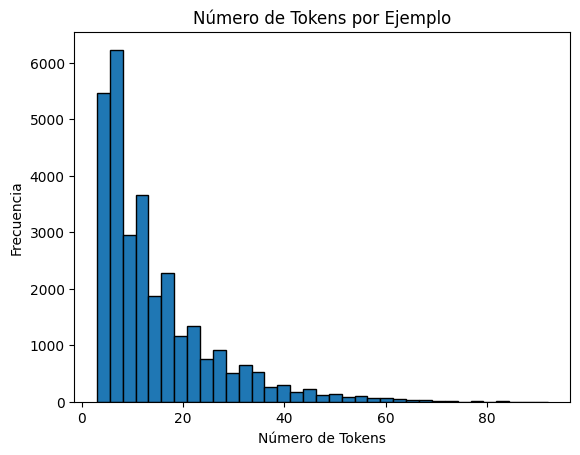

Total de ejemplos: 30000
Percentil 25: 6.0
Percentil 50 (Mediana): 11.0
Percentile 75: 19.0
Max: 92


In [ ]:
# @markdown ❗
# Generación de histograma de número de tokens por ejemplos
import matplotlib.pyplot as plt
import numpy as np

# Cálculo de número de tokens por ejemplos
def count_tokens_fn(batch):
    tokenized_batch = tokenizer(batch['samples'])
    tokenized_batch['count'] = [len(tks) for tks in tokenized_batch['input_ids']]
    return tokenized_batch

result = bert_ds.map(
    function=count_tokens_fn,
    batched=True
)

num_of_tokens_list = result['train']['count'][:] + result['test']['count'][:]

# Generación de histograma
plt.hist(num_of_tokens_list, bins=35, edgecolor='k')
plt.xlabel('Número de Tokens')
plt.ylabel('Frecuencia')
plt.title('Número de Tokens por Ejemplo')
plt.show()

# Cálculo de percentiles (e.g., 25th, 50th, and 75th percentiles)
percentiles = np.percentile(num_of_tokens_list, [25, 50, 75])

print(f"Total de ejemplos: {len(num_of_tokens_list)}")
print(f"Percentil 25: {percentiles[0]}")
print(f"Percentil 50 (Mediana): {percentiles[1]}")
print(f"Percentile 75: {percentiles[2]}")
print(f"Max: {np.max(num_of_tokens_list)}")

- A continuación, la función auxiliar `tokenize_data_fn` servirá para tokenizar y codificar el conjunto completo de datos de manera eficiente mediante el [método `map`](https://huggingface.co/docs/datasets/about_map_batch).
- Lo que devolverá será un nuevo dataset cuyos tokens estarán ''convertidos'' en:
    - índices del vocabulario (*input_ids*),
    - máscaras de atención [(*attention_mask*)](https://huggingface.co/docs/transformers/glossary#attention-mask),
    - tipos de tokens [(*token_type_ids*)](https://huggingface.co/docs/transformers/glossary#token-type-ids),
    - y etiquetas (*labels*) que serán utilizadas como `Ground Truth` en la etapa de entrenamiento.
- `MAX_TOKEN_LENGTH`: Indica el máximo número de tokens que el modelo utilizará para codificar cada ejemplo/muestra. Debemos aumentarlo cuando los ejemplos de nuestro conjunto de datos son más largos, pero cuanto más largos son, más espacio ocupan en la memoria. Una estrategia común para determinar el tamaño máximo de tokens es realizar un histograma y quedarnos con el valor del percentil 75% del largo de los ejemplos. También podemos utilizar el número de tokens de la secuencia más larga si disponemos de suficiente capacidad de memoria.

In [ ]:
# @markdown ❗
# Tokenización de conjunto de datos completo

# Número máximo de tokens a utilizar
MAX_TOKEN_LENGTH = 48 # @param {type:"slider", min:8, max:128, step:8}

def tokenize_data_fn(batch):
    tokenized_sample = tokenizer(
        batch['samples'],
        max_length=MAX_TOKEN_LENGTH,
        truncation=True,
        padding='max_length',
        return_tensors='pt',
    )

    tokenized_sample["labels"] = tokenized_sample['input_ids'].clone()
    return tokenized_sample

tokenized_bert_ds = bert_ds.map(
    function=tokenize_data_fn,
    batched=True,
    remove_columns=["samples"]
)

print(tokenized_bert_ds)

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 24000
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 6000
    })
})


In [ ]:
# @markdown 🔎
# Visualización de proceso de tokenización para el primer ejemplo del conjunto de datos
sample = tokenized_bert_ds["train"][0]

print(f"- input_ids:        {sample['input_ids']}")
print(f"- attention_mask:   {sample['attention_mask']}")
print(f"- token_type_ids:   {sample['token_type_ids']}")
print(f"- labels:           {sample['labels']}")

- input_ids:        [4, 1009, 1277, 24304, 17065, 1050, 5157, 30955, 1091, 20512, 30956, 8745, 1009, 19090, 25780, 1040, 24729, 1009, 20785, 1008, 29918, 7270, 3256, 13331, 1035, 1039, 25733, 1020, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
- attention_mask:   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
- token_type_ids:   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
- labels:           [4, 1009, 1277, 24304, 17065, 1050, 5157, 30955, 1091, 20512, 30956, 8745, 1009, 19090, 25780, 1040, 24729, 1009, 20785, 1008, 29918, 7270, 3256, 13331, 1035, 1039, 25733, 1020, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### Enmascarado Aleatorio

> Este proceso es el encargado de ocultar aleatoriamente el 15\% de los tokens y formatear los datos de entrenamiento de manera adecuada, asegurando que las secuencias de entrada tengan la longitud correcta y que las máscaras de atención se apliquen correctamente.

* Para implementar este proceso de manera sencilla, utilizaremos el método [DataCollatorForLanguageModeling](https://huggingface.co/docs/transformers/v4.32.1/en/main_classes/data_collator#transformers.DataCollatorForLanguageModeling) proporcionado por la biblioteca de Hugging Face.

* Como se podrá observar en el siguente ejemplo, es común utilizar un valor especial como **-100** en la salida de las etiquetas (*labels*) para indicar la posición de los tokens que se **IGNORAN** en el cálculo de la función de pérdida llevada a cabo durante el entrenamiento.

In [ ]:
# @markdown ❗
import torch, random
from transformers import DataCollatorForLanguageModeling

data_collate_fn = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm_probability=0.15
)

In [ ]:
# @markdown 🔎
# Visualizacion de proceso de 'enmascarado aleatorio' de tokens
seed = random.randint(0,100)
samples = [tokenized_bert_ds['train'][i] for i in range(3)]

print("DataCollator Outputs")
torch.manual_seed(seed)
print("--- Tokens:")
for sample in data_collate_fn(samples)['input_ids']:
    print(f">> {[tokenizer.decode([tk]) for tk in sample]}'")

torch.manual_seed(seed)
print("\n--- 'input_ids':")
for sample in data_collate_fn(samples)['input_ids']:
    print(f">> {sample.tolist()}'")

torch.manual_seed(seed)
print("\n--- 'labels':")
for sample in data_collate_fn(samples)['labels']:
    print(f">> {sample.tolist()}")

DataCollator Outputs
--- Tokens:
>> ['[CLS]', 'de', 'este', 'embo', '##tella', '##do', 'emerg', '##e', 'una', 'vistos', 'luego', 'nariz', 'de', 'perfume', 'violeta', 'y', 'caramelo', 'de', 'uva', '.', 'sabores', 'similares', 'pers', '##isten', 'en', 'el', 'palad', '[MASK]', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']'
>> ['[CLS]', 'la', 'especi', '##a', 'ceda', '##ria', 'nota', 'aroma', '##s', 'acento', 'de', 'fra', '##mb', '##ues', '##a', 'y', '[MASK]', '[MASK]', 'en', 'este', 'vino', 'firme', '.', 'el', 'palad', '##ar', 'es', '[MASK]', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']'
>> ['[CLS]', 'fruta', 'oscura', '[MASK]', '##uber', '##ante', 'y', 'enorme', 'complejidad', '[MASK]', '##mática', '[MASK]', 'cere', '##za',

### Probando el Modelo Base

- Antes de **personalizar** (adaptar) el modelo a nuestro conjunto de datos seleccionado, veremos cómo se desenvuelve en la tarea de *fill-mask*.

- Para ello, escriba una frase muy característica del dominio al que se quiere adaptar, y enmascare alguna de sus palabras utilizando el token `[MASK]`.


In [ ]:
# @markdown 🔎
# Ejemplo para español, pensando en adaptar el modelo a Peppa Pig
# Usamos pipeline como función auxiliar de alto nivel
from transformers import pipeline

fill_mask = pipeline(
    task="fill-mask",
    model="dccuchile/bert-base-spanish-wwm-uncased",
    top_k=5
)

ejemplo = 'Un vino con [MASK] afrutado' # @param {type:"string"}
fill_mask(ejemplo)

Device set to use cuda:0


[{'score': 0.1523466408252716,
  'token': 1044,
  'token_str': 'un',
  'sequence': 'un vino con un afrutado'},
 {'score': 0.13129745423793793,
  'token': 9365,
  'token_str': 'toque',
  'sequence': 'un vino con toque afrutado'},
 {'score': 0.1203673705458641,
  'token': 3635,
  'token_str': 'vino',
  'sequence': 'un vino con vino afrutado'},
 {'score': 0.08484091609716415,
  'token': 1039,
  'token_str': 'el',
  'sequence': 'un vino con el afrutado'},
 {'score': 0.06266046315431595,
  'token': 1086,
  'token_str': 'lo',
  'sequence': 'un vino con lo afrutado'}]

In [ ]:
# @markdown 🔎
# Ejemplo para inglés, pensando en adaptar el modelo a VizWiz
# Usamos pipeline como función auxiliar de alto nivel
from transformers import pipeline

fill_mask = pipeline(
    task="fill-mask",
    model="bert-base-uncased",
    top_k=5
)

ejemplo = "Can you [MASK] me the model on the back of the iPhone?" # @param {type:"string"}
fill_mask(ejemplo)

### Entrenamiento para adaptación

- Una vez definido el conjunto de datos y completado el proceso de tokenización, pasemos a la parte más intensa computacionalmente, el entrenamiento.
- A continuación, definimos las configuraciones del entrenamiento mediante [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.TrainingArguments).
- ... y definimos el entrenamiento del modelo mediante la clase  [`Trainer`](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.Trainer).
    
> <u>Detalles de parámetros a configurar</u>:
1.   ***epochs***: Número de épocas de entrenamiento. En cada epoch, el algoritmo de entrenamiento recibe cada uno de los ejemplos del dataset de entrenamiento.
2.  ***batch_size***: Cantidad de datos procesados por iteración antes de actualizar el modelo (aumentar este número mejora las estimaciones de cada iteración ya que será una muestra más representativa del dataset en general, pero requerirá más memoria y será necesario monitorizar y re-ajustar el `learning_rate`)
3.  ***learning_rate***:  Tamaño del ''ajuste'' realizado en el modelo en cada iteración, mientras se avanza hacia un mínimo de la función de pérdida.

**Nota**: El valor de estos parámetros, en conjunción al poder de cómputo disponible, determinará el tiempo y la cantidad de cálculo requerido para poder realizar el entrenamiento del modelo. Puede ir desde unos segundos hasta varios minutos.


In [ ]:
# @markdown ❗
from transformers import TrainingArguments, Trainer, BertForMaskedLM

# Eliminación de checkpoints anteriores
!rm -r "$CUSTOM_MODEL_CHECKPOINT"

# Configuración de hiperparámetros
MODEL_CHECKPOINT = "dccuchile/bert-base-spanish-wwm-uncased" # @param ["dccuchile/bert-base-spanish-wwm-uncased", "bert-base-uncased"]
BATCH_SIZE = 64 # @param {type:"slider", min:8, max:64, step:8}
LEARNING_RATE = 2e-5 # @param {type:"number"}
EPOCHS = 5 # @param {type:"slider", min:3, max:15, step:1}
LOGGING_STEPS = len(tokenized_bert_ds["train"]) // BATCH_SIZE
CUSTOM_MODEL_CHECKPOINT = "bert_adaptation_" + DATASET_NAME.replace(" ", "_")[:-5].lower()

# Configuración de entrenamiento
training_args = TrainingArguments(
    output_dir=CUSTOM_MODEL_CHECKPOINT,
    overwrite_output_dir=True,
    #evaluation_strategy="epoch",
    num_train_epochs=EPOCHS,
    optim='adamw_torch',
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    push_to_hub=False,
    fp16=True,
    logging_steps=LOGGING_STEPS,
    report_to="none",
    save_strategy="no"
)

# Instanciación de modelo
model = BertForMaskedLM.from_pretrained(MODEL_CHECKPOINT)

# Instanciación de clase Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_bert_ds["train"],
    eval_dataset=tokenized_bert_ds["test"],
    data_collator=data_collate_fn,
    tokenizer=tokenizer,
)

trainer.args._n_gpu = 1

rm: cannot remove '': No such file or directory


/tmp/ipython-input-769852039.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


* Antes de comenzar el entrenamiento, calcularemos la [**Perplexity**](https://huggingface.co/docs/transformers/perplexity) del modelo de lenguaje.

> La `Perplexity` es una métrica que nos permite evaluar cuánta incertidumbre tiene un modelo cuando tiene que predecir palabras en un conjunto de prueba determinado. La misma, ayuda a medir qué tan bien conoce el modelo el lenguaje, y cuán coherentes serán sus predicciones. En general, una *perplejidad* más baja indicará que el modelo genera textos que claramente pertenecen al lenguaje.
<center>
<img src="https://thegradient.pub/content/images/size/w1600/2020/04/xkcd_entropy-2.png" width=50%>
</center>
fuente: https://thegradient.pub/understanding-evaluation-metrics-for-language-models/

Si queremos evaluar qué tanto se adapta un modelo a un dominio determinado, podemos estimar su perplejidad para las tareas de completar palabras (MLM) o generación de texto en oraciones del dominio de interés, ya sea sobre conjunto de oraciones que nos interesen particularmente (un *benchmark* o *testbed*) o sobre un  corpus representativo del dominio en general.

> Los animamos a crear un mini-testbed, una listita de oraciones que les permita ver rápidamente qué pasa con diferentes tipos de adaptaciones. Les va a servir mucho para monitorear de forma sistemática los cambios en su sistema! Luego pueden compartir sus testbeds con la comunidad, un buen testbed vale oro :-).

In [ ]:
# @markdown  🔎
import math

# Fijamos semilla para reproducibilidad de resultados
torch.manual_seed(42)

# Estimación de perplexity previa a entrenamieto
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 286.00


In [ ]:
# @markdown ❗⏳
# Inicio de entrenamiento
trainer.train()

# Guardado de entrenamiento
trainer.save_model(CUSTOM_MODEL_CHECKPOINT)

Step,Training Loss
375,3.165100
750,2.515800
1125,2.337600
1500,2.266100
1875,2.174800



* Ahora, estimemos nuevamente la `perplexity` del modelo y comparemos con el valor obtenido previamente.

In [ ]:
# @markdown 🔎
# Fijamos semilla para reproducibilidad de resultados
torch.manual_seed(42)

# Estimación de perplexity posterior a entrenamiento
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 9.10



### Probando el Modelo Adaptado

- Ahora que tenemos el modelo entrenado con el dataset específico, la pregunta es, ¿Cómo se comportará?
- Para ello volvemos a hacer la prueba anterior utilizando la tarea de *fill-mask*, quizás esta vez con resultados más ajustados al dominio. Acá es donde se luce un buen testbed!
- Para que los resultados sean mas fáciles de comparar, la función `compare_models()` será la encargada de procesar y retornar, para cada oraión de ejemplo ingresada, un ranking comparativo de las predicciones realizadas entre el nuevo modelo adaptado y el modelo base original.

In [ ]:
# @markdown ❗
import os
import transformers
from typing import List
from tabulate import tabulate
from transformers import pipeline

# Función auxiliar para comparación de predicciones de modelos
def compare_models(
    custom_model: transformers.pipelines.fill_mask.FillMaskPipeline,
    base_model: transformers.pipelines.fill_mask.FillMaskPipeline,
    sentences: List[str],
    top_k=5
) -> None:

    headers = ['Sent','Custom Bert', '(%)', 'Base Bert', '(%)']
    rows = []
    for sent in sentences:
        rows.append([sent, '', '', '', ''])

        c_out = custom_model(sent)
        o_out = base_model(sent)

        c_tokens = [(i['token_str'], str(round(i['score']*100,1))+"%") for i in c_out]
        o_tokens = [(i['token_str'], str(round(i['score']*100,1))+"%") for i in o_out]

        for (p1,s1), (p2,s2) in zip(c_tokens, o_tokens):
            rows.append(['', p1, s1, p2, s2])

    table = tabulate(rows, headers=headers, tablefmt="text", numalign="center")
    print(table, "\n")

# Instanciación de modelo personalizado y modelo base
base_model = pipeline(task="fill-mask", model=MODEL_CHECKPOINT)
custom_model = pipeline(task="fill-mask", model=CUSTOM_MODEL_CHECKPOINT)

Device set to use cuda:0
Device set to use cuda:0


In [ ]:
# @markdown ❗

# Conjunto de ejemplos de prueba
vizwiz_test_examples = [
    "can you tell me the title of the book? [MASK].",
    "please [MASK] this shirt",
    "what [MASK] is this?",
    "[MASK] can you tell me what is this?",
    "how clear is this [MASK]?",
    "is the floor [MASK]?",
    "the microwave is [MASK]?."
]

vinos_test_examples = [
    "Este [MASK] argentino de altura es una verdadera",
    "Con un color profundo e [MASK]",
    "Los sabores de [MASK] persisten",
    "Hecho 100% de [MASK]",
    "El sabor fue [MASK]",
    "Con su [MASK] mezcla de minerales",
    "Por primera vez en [MASK],"
]

martin_fierro_test_examples = [
    "En los campos de la [MASK] extensa",
    "donde el viento y el sol se [MASK]",
    "cabalgo firme con mi [MASK]",
    "bajo el cielo de [MASK] risueño",

    "Con mi [MASK] y mi lazo",
    "enfrento a la [MASK] con valor",
    "batiéndome siempre a mi [MASK]",
    "en este ancho y rudo [MASK]",

    "Así cabalgo con alma [MASK]",
    "como otros en su [MASK]",
    "defendiendo mi [MASK] y mi gente",
    "en esta tierra que [MASK] sin cesar",

    "Con [MASK] al cinto, firme y diestro",
    "Enfrento [MASK], firme como el resto",
    "Mate en mano, bajo el cielo [MASK]",
    "Mi coraje y mi [MASK], jamás han claudicado."
]

peppa_pig_test_examples = [
    "[MASK], puedes decir dinosarurio?",
    "¡Hola, soy Peppa [MASK]!",
    "George tiene un [MASK] muy querido.",
    "El sol brilla en el [MASK] del jardín.",
    "Peppa y George juegan en el [MASK].",
    "Mamá Pig prepara [MASK] deliciosos.",
    "Vamos al [MASK] para montar en bicicleta.",
    "El [MASK] está lleno de flores hermosas.",
    "Peppa y sus amigos tienen [MASK] en el parque."
]

# Moficar 'sentences' acorde al conjunto de datos utilizado para la personalización
compare_models(
    custom_model=custom_model,
    base_model=base_model,
    sentences=vinos_test_examples
)

Sent                                              Custom Bert    (%)    Base Bert      (%)
------------------------------------------------  -------------  -----  -------------  -----
Este [MASK] argentino de altura es una verdadera
                                                  vino           45.9%  gigante        5.9%
                                                  rosado         8.5%   salto          5.7%
                                                  blanco         7.5%   ejemplar       4.7%
                                                  rojo           3.7%   pico           2.9%
                                                  estilo         2.9%   argentino      2.2%
Con un color profundo e [MASK]
                                                  intenso        74.0%  intenso        78.1%
                                                  informal       8.1%   impresionante  3.2%
                                                  intensidad     4.2%   increible      1.9%

> Este trabajo está licenciado bajo [Licencia MIT](https://github.com/nanom/llm_adaptation_2nlp_workshop/blob/main/LICENSE).

# 4. **Obteniendo Embeddings Contextualizados**
Lo primero que vamos a hacer es **transformar una frase en su representación vectorial usando BERT**. Por defecto, la dimensión de la salida es 768, es decir, cada token en mi frase va a ser representado por un vector de 768 elementos.

In [ ]:
# @markdown ❗
# Obteniendo Embeddings Contextualizados de las palabras del modelo custom_model
# Usaremos el custom_model para obtener los embeddings contextualizados.
# La dimensión de salida por defecto es 768.
from transformers import BertForMaskedLM

# Cargar el custom model
model = BertForMaskedLM.from_pretrained(CUSTOM_MODEL_CHECKPOINT)

# Si tienes una GPU, mueve el modelo a la GPU
if torch.cuda.is_available():
    model.to('cuda')

In [ ]:
# Lo primero que hacemos es tokenizar nuestra frase
# 'pt' especifica que queremos vectores de pytorch, 'tf' seria en tensorflow
inputs = tokenizer("Un vino con perfil aromático", return_tensors="pt")

inputs = {k: v.to(model.device) for k, v in inputs.items()}
inputs

{'input_ids': tensor([[    4,  1044,  3635,  1048,  9471, 10975,  6849,     5]],
        device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [ ]:
# Luego le pasamos la frase tokenizada al modelo pre-entrenado
outputs = model(**inputs, output_hidden_states=True, return_dict=True)

# Aqui el doble asterico es una forma de pasar multiples parámetros a una función desde un único diccionario, por ejemplo:
# d = {'a': 1, 'b':2}; model(**d) sería equivalente a pasar cada variable como: model(a=1,b=2)


# El ultimo hidden-state es la transformación en embeddings que nos interesa.
# Para convencerse pueden pensar que es el último paso antes de aplicar una softmax.
last_hidden_states = outputs.hidden_states[-1].squeeze(0) # squeeze en la primera dimension ya que es 1

print(inputs['input_ids']) # Tenemos 8 tokens, contando el CLS (101) y el SEP (102)
print(last_hidden_states.shape) # Tenemos 8 vectores de 768 dimensiones
print(last_hidden_states)

tensor([[    4,  1044,  3635,  1048,  9471, 10975,  6849,     5]],
       device='cuda:0')
torch.Size([8, 768])
tensor([[-0.6050,  0.0987, -0.4510,  ..., -0.1339,  0.0413,  0.1176],
        [-0.4210, -0.1894, -0.1976,  ...,  0.0970, -0.2093, -0.6250],
        [-0.9018,  0.3701,  0.1155,  ...,  0.3168,  0.0172, -0.5820],
        ...,
        [-0.5462,  0.6439,  0.0070,  ...,  0.1265,  0.2232, -0.3253],
        [-0.2892,  0.1322, -0.9794,  ...,  0.7567,  0.2456, -0.4402],
        [-0.6097,  0.0930, -0.4661,  ..., -0.1206,  0.0338,  0.1002]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


### **Obtener representación de una oración desde el último hidden-state**

Quizás en vez de trabajar con **Word Embeddings** nos convenga trabajar con **Sentence Embedding**. Podemos pensar en un Sentence Embedding con **la mezcla** de los Words Embedding de mi input. Los autores de BERT usaban el token [CLS] para este propósito, aunque no es muy recomendado, ya que depende del **fine tunning** (veremos esto más adelante). Otra opción, mucho más usada,es tomar el **promedio de todos mis word embeddings**. Hay más formas de pooling (es decir como se mezclan los tokens), por ejemplo, podemos ver las de bert-as-service [acá](https://bert-as-service.readthedocs.io/en/latest/section/faq.html#what-are-the-available-pooling-strategies).

In [ ]:
# Representacion con average
# Recordemos que nuestra frase tokenizada tiene 8 elementos
# y que el primero y el ultimo son tokens especiales: [CLS] y [SEP], por lo que los descartamos.
average = torch.mean(last_hidden_states[1:-1], 0)
print(average.shape)


torch.Size([768])


# 5. Clasificando texto con Bert

## BERT como extractor de features

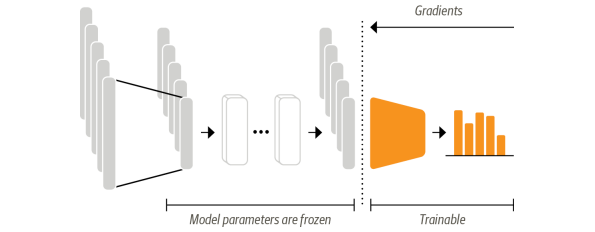

La idea detrás de esta tarea es utilizar una red pre-entrenada de BERT para generar solamente Features, tal cual como usábamos Word2Vec peroo quizás un poquito…. (si un poquito nomas) más complicado por el uso extracto de ciertos tokenizadores y extracción de hidden states.

Para esto comenzaremos cargando el `distilbert-base-uncased`, con el que realizaremos  una tarea de clasificación de sentimientos.

Para este ejemplo nos basamos en un ejercicio del libro `Natural Language
Processing with Transformers`.

In [32]:
from transformers import AutoTokenizer
from transformers import AutoModel
from datasets import load_dataset
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model_distilbert = AutoModel.from_pretrained(model_ckpt).to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [33]:
# Cargamos un dataset que forma parte de la librería datasets
emotions = load_dataset("emotion")

README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [34]:
# Revisamos algunos ejemplos para ver que tiene
emotions['train']['text'][:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

In [35]:
emotions['train']['label'][:5]

[0, 0, 3, 2, 3]

Paso siguiente, como queremos generar features utilizando BERT, crearemos unas funciones que nos permiten extraer los hidden state del modelo de BERT. Finalmente generaremos un dataset en el formato ultra conocido de DataSet para entrenar un modelito pequeño.

In [36]:
def tokenize(batch):
  # Por cada batch vamos a obtener el texto, tokenizarlo y aplicar padding
  return tokenizer(batch["text"], padding=True, truncation=True)

def extract_hidden_states(batch):
 # Vamos a extraer los hidden states desde BERT, para esto pasamos el modelo
 # dispositivo
 inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
 # Extraemos solamente la last hidden state
 with torch.no_grad():
   last_hidden_state = model_distilbert(**inputs).last_hidden_state
 # representaciones vectoriales que tanto queriamos :D
 return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

# Aplicamos funciones creadas
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label", "text"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [37]:
# Revisamos que tiene el dataset creado
emotions_hidden['train']

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
    num_rows: 16000
})

Generamos las estructuras "clasicas" para entrenar un modelo de regresión logistica mas tarde.

In [38]:
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

Pregunta.... ¿cómo se ven las features?... Antes de entrenar y predecir el desempeño del modelo vamos a ver representaciones visuales de las features, para ver si estas tienen una tendencia a generar patrones en los datos. Para esto utilizamos un reductor de dimensionalidad llamado TSNE (ya que más de 3d es imposible ver para nosotros) y... probamos!

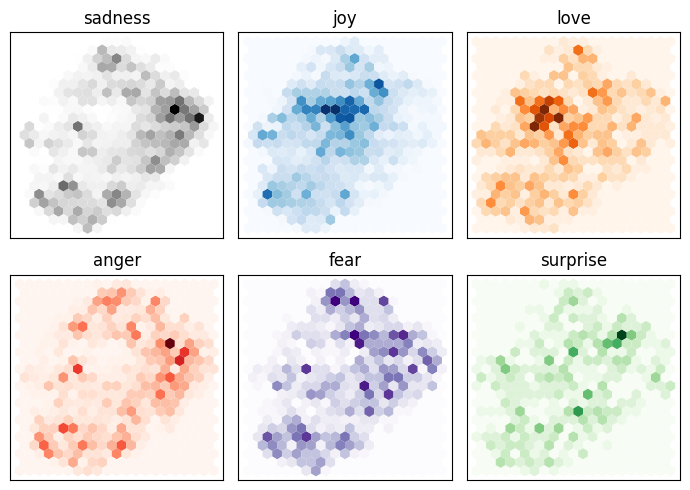

Como podemos ver, las palabras tienden a agruparse de diferente manera según los sentimientos, esto resulta muy interesante, ya que potencialmente un clasificador podrá identificar estos patrones 😯.

Probemos con un clasificador ultra basico, la muy bien conocida Regresión logistica

In [40]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=5000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.634

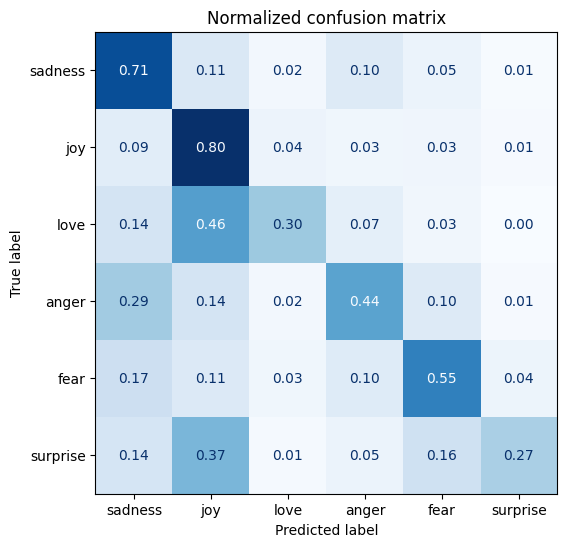

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
labels = emotions["train"].features["label"].names
def plot_confusion_matrix(y_preds, y_true, labels):
 cm = confusion_matrix(y_true, y_preds, normalize="true")
 fig, ax = plt.subplots(figsize=(6, 6))
 disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
 disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
 plt.title("Normalized confusion matrix")
 plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

De los resultados, resulta interesante que a través de las features generadas logremos un modelo que logra discernir ante varias labels utilizando solamente un clasificador tan básico como logistic regression.

## Uso de AutoModelForSequenceClassification

Usaremos AutoModelForSequenceClassification, el cual incluye una arquitectura predefinida para resolver problemas de clasificación. [Para más información](https://medium.com/@namanlazarus/under-the-hood-of-automodelforsequenceclassification-in-hugging-face-transformers-e497bc78d828)

In [47]:
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=256)

tok_ds = emotions.map( # Generamos tokens para el dataset emotions
    tokenize, batched=True,
)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [49]:
import evaluate
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer

id2label = {0:"sadness", 1:"joy", 2:"love", 3:"anger", 4:"fear", 5:"surprise"}
label2id = {"sadness":0,"joy":1,"love":2,"anger":3, "fear":4, "surprise":5}

# ============================================
# MODELO DE CLASIFICACIÓN
# --------------------------------------------
# AutoModelForSequenceClassification agrega automáticamente:
# - Dropout + capa lineal final (cabeza de clasificación)
# - Cálculo de pérdida CrossEntropy cuando se pasan "labels"

# Corrected: Use the model identifier string instead of the model object
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=6, id2label=id2label, label2id=label2id
)

# DataCollatorWithPadding aplica padding dinámico a cada batch,
# lo que ahorra memoria frente a padear todo al max_length global.
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Métricas con la librería "evaluate"
metric_acc = evaluate.load("accuracy")
metric_f1  = evaluate.load("f1")

# Función que el Trainer llamará para calcular métricas al final de cada evaluación
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return {
        "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
args = TrainingArguments(
    output_dir="./beto-sentiment-es",
    report_to="none",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,              # 3–4 si tienes GPU
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    logging_steps=50
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tok_ds["train"].shuffle(seed=42).select(range(5000)),  # submuestreo opcional con muestreo aleatorio
    eval_dataset=tok_ds["validation"],
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics
)

# Entrenar
trainer.train()

# Evaluar en test
test_metrics = trainer.evaluate(tok_ds["test"])
test_metrics

/tmp/ipython-input-2081206715.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.598900,0.523672,0.823500,0.693996
2,0.334500,0.338323,0.894000,0.837057


{'eval_loss': 0.3367081880569458,
 'eval_accuracy': 0.8935,
 'eval_f1_macro': 0.8179156854398121,
 'eval_runtime': 2.8738,
 'eval_samples_per_second': 695.939,
 'eval_steps_per_second': 21.922,
 'epoch': 2.0}

In [55]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd # Import pandas
import numpy as np

# Genera reporte y matriz de confusión en el split de test.
def evaluar_detallado(dataset, trainer, max_items=5000):
    """
    Evalúa el modelo en un subconjunto del test (por default 2000 ejemplos para ir rápido).
    Retorna un DataFrame con verdaderos/predichos y muestra reporte + matriz de confusión.
    """
    # Seleccionar un subconjunto (quita el select para usar todo el test)
    ds_small = dataset.select(range(min(max_items, len(dataset))))

    # Obtener logits con Trainer (vectorizados y rápidos)
    preds_out = trainer.predict(ds_small)
    y_true = np.array(ds_small["label"])
    y_pred = preds_out.predictions.argmax(-1)

    print("\n=== Classification report (test) ===")
    # Explicitly specify the labels to include in the report
    print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(6)], labels=[0, 1, 2, 3, 4, 5]))

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5])
    df_cm = pd.DataFrame(cm, index=[id2label[i] for i in range(6)],
                            columns=[id2label[i] for i in range(6)])
    print("\n=== Matriz de confusión ===")
    print(df_cm)
    return pd.DataFrame({"y_true": y_true, "y_pred": y_pred})


_df_eval = evaluar_detallado(tok_ds["test"], trainer)


=== Classification report (test) ===
              precision    recall  f1-score   support

     sadness       0.93      0.94      0.94       581
         joy       0.89      0.95      0.92       695
        love       0.81      0.68      0.74       159
       anger       0.89      0.88      0.88       275
        fear       0.85      0.90      0.87       224
    surprise       0.84      0.41      0.55        66

    accuracy                           0.89      2000
   macro avg       0.87      0.79      0.82      2000
weighted avg       0.89      0.89      0.89      2000


=== Matriz de confusión ===
          sadness  joy  love  anger  fear  surprise
sadness       546   13     2     12     8         0
joy             9  662    21      3     0         0
love            2   45   108      4     0         0
anger          18    5     3    242     7         0
fear            5    1     0     11   202         5
surprise        4   14     0      0    21        27


### Inferencia (predicción en texto nuevo)

In [53]:
import torch.nn.functional as F
import torch

def clasificar(texto):
  """
  Tokeniza un texto y devuelve (etiqueta_predicha, probabilidad_max).
  """
  enc = tokenizer(texto, return_tensors="pt", truncation=True, max_length=256)
  # Move input tensors to the same device as the model
  enc = {k: v.to(model.device) for k, v in enc.items()}
  with torch.no_grad():
      out = model(**enc)
  probs = F.softmax(out.logits, dim=-1).squeeze()
  pred = int(probs.argmax())
  return id2label[pred], float(probs[pred])

# Ejemplo:
clasificar("Este producto me encantó")

('joy', 0.6998156905174255)